# Estimate Porosity using 3D image with 2 silces of rock images --- CNN

In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from skimage import io
from skimage.filters import threshold_otsus
import cv2
import os

In [2]:
raw_file = np.fromfile('Berea_2d25um_grayscale_filtered.raw', dtype=np.uint8)
image = (raw_file.reshape(1000,1000,1000))
#image = image==0

### randomly crop sub-image from the RAW 3D image in the size of 256*256 2D image
#### crop 400 images in total

In [3]:
def random_crop_and_save(image, num_crops=400, crop_size=(256, 256), save_dir='CroppedImages'):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    depth, height, width = image.shape
    for i in range(num_crops):
        # Randomly choose the top-left pixel of the crop
        z = np.random.randint(0, depth - crop_size[0])
        y = np.random.randint(0, height - crop_size[1])
        x = np.random.randint(0, width - crop_size[1])  # square crops (128x128)

        # Perform the crop
        cropped_image = image[z, y:y+crop_size[1], x:x+crop_size[1]]
        
        # Save the cropped image
        filename = os.path.join(save_dir, f'crop_{i+1:04d}.png')
        cv2.imwrite(filename, cropped_image)

random_crop_and_save(image)


### calculate porosity 

##### OTSU'method to make it binary image and using watersheld alriorithen to makea thersholds

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def calculate_porosity(image_path):
    
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
    dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY)
    sure_fg = sure_fg.astype(np.uint8)
    unknown = cv2.subtract(sure_bg, sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(img, markers)

    labels = np.unique(markers)
    total_pore_area = 0

    for label in labels[2:]:  
        target = np.where(markers == label, 255, 0).astype(np.uint8)
        contours, hierarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        total_pore_area += cv2.contourArea(contours[0])

    total_image_area = img.shape[0] * img.shape[1]
    porosity = total_pore_area / total_image_area
    return porosity

cropped_images_dir = 'CroppedImages'
PorosityValues = {}

for i in range(1, 401): 
    filename = f"crop_{i:04d}.png"
    image_path = os.path.join(cropped_images_dir, filename)
    porosity = calculate_porosity(image_path)
    PorosityValues[filename] = porosity

# Optionally, save porosity values to a file
with open('PorosityValues.txt', 'w') as f:
    for filename, porosity in PorosityValues.items():
        f.write(f"{filename}: {porosity}\n")


print(PorosityValues)

{'crop_0001.png': 0.14403533935546875, 'crop_0002.png': 0.15845489501953125, 'crop_0003.png': 0.17826080322265625, 'crop_0004.png': 0.12769317626953125, 'crop_0005.png': 0.12116241455078125, 'crop_0006.png': 0.15771484375, 'crop_0007.png': 1.0467758178710938, 'crop_0008.png': 0.16419219970703125, 'crop_0009.png': 0.1380462646484375, 'crop_0010.png': 0.176116943359375, 'crop_0011.png': 0.14150238037109375, 'crop_0012.png': 0.2060546875, 'crop_0013.png': 0.1136322021484375, 'crop_0014.png': 1.0495529174804688, 'crop_0015.png': 0.17128753662109375, 'crop_0016.png': 0.1695556640625, 'crop_0017.png': 0.160064697265625, 'crop_0018.png': 0.20795440673828125, 'crop_0019.png': 0.2271575927734375, 'crop_0020.png': 0.189056396484375, 'crop_0021.png': 0.13980865478515625, 'crop_0022.png': 0.13248443603515625, 'crop_0023.png': 0.18773651123046875, 'crop_0024.png': 0.12273406982421875, 'crop_0025.png': 0.14524078369140625, 'crop_0026.png': 0.1592559814453125, 'crop_0027.png': 0.141143798828125, 'cro

### Spliting data

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

X = []
y = []

for filename, porosity in PorosityValues.items():
    img_path = os.path.join(cropped_images_dir, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))  # Ensure all images are the same size
    X.append(img)
    y.append(porosity)

X = np.array(X).reshape(-1, 128, 128, 1)
y = np.array(y)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.4 = 0.1


### CNN MODLE Build up

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout,Input
from tensorflow.keras.optimizers import Adam
CNNmodel = Sequential([
    
    # First Conv Block
    Input(shape=(128, 128, 1)), 
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), padding="same"),
    
    # Second Conv Block
    Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), padding="same"),
    
    # Third Conv Block
    Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), padding="same"),
    
    # Fourth Conv Block
    Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), padding="same"),
    
    # Fifth Conv Block
    Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), padding="same"),
    
    # Flattening & Dense Layers
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.2),  
    Dense(1, activation='linear')  # 
])


In [7]:
from tensorflow.keras.losses import Huber

huber_loss = Huber(delta=0.5)


CNNmodel.compile(optimizer="adam", loss=huber_loss, metrics=['mae']) 


history = CNNmodel.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 6.3483 - mae: 13.0197 - val_loss: 15.7845 - val_mae: 31.8198
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 1.3124 - mae: 2.8825 - val_loss: 2.4229 - val_mae: 5.0995
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.1812 - mae: 0.5617 - val_loss: 2.6962 - val_mae: 5.6420
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.0626 - mae: 0.2758 - val_loss: 0.0082 - val_mae: 0.0831
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0272 - mae: 0.1887 - val_loss: 0.0406 - val_mae: 0.2529
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.0147 - mae: 0.1208 - val_loss: 0.0840 - val_mae: 0.3984
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.0172 - mae: 0.1290 - val_loss: 0.0134 - val_mae: 0.1359
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0128 - mae: 0.1127 - val_loss: 0.0124 - val_mae: 0.1304
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 0.0084 - ma

In [8]:
test_loss, test_mae = CNNmodel.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010 - mae: 0.0348    
Test MAE: 0.03566306084394455


In [9]:
predicted_porosity = CNNmodel.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


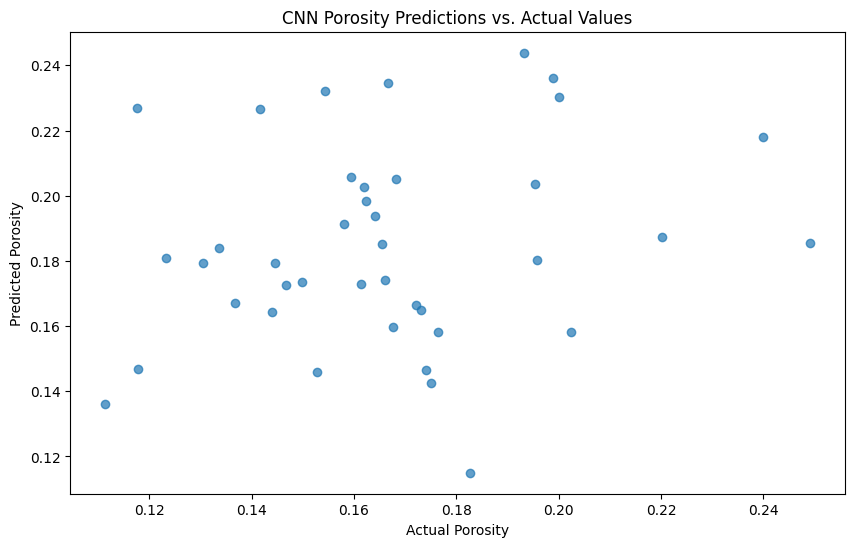

In [10]:
import matplotlib.pyplot as plt


actual_porosity = y_test

plt.figure(figsize=(10, 6))
plt.scatter(actual_porosity, predicted_porosity, alpha=0.7)
plt.title('CNN Porosity Predictions vs. Actual Values')
plt.xlabel('Actual Porosity')
plt.ylabel('Predicted Porosity')
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actual_porosity, predicted_porosity)
mse = mean_squared_error(actual_porosity, predicted_porosity)
r2 = r2_score(actual_porosity, predicted_porosity)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 0.035663063265383245
Mean Squared Error: 0.0018000729161549837
R-squared: -0.9330521116333934


In [12]:
Average_predicted_porosity = np.average(predicted_porosity)
Average_predicted_porosity = Average_predicted_porosity*100
print("The porosity for the testing data %0.2f" %Average_predicted_porosity, "%")

The porosity for the testing data 18.44 %


# APPENDIX
## **Example after remove noise, sugement and therhods** (using image "Crop_0000.png")

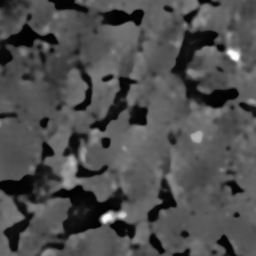

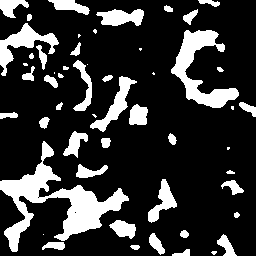

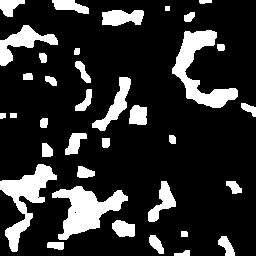

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


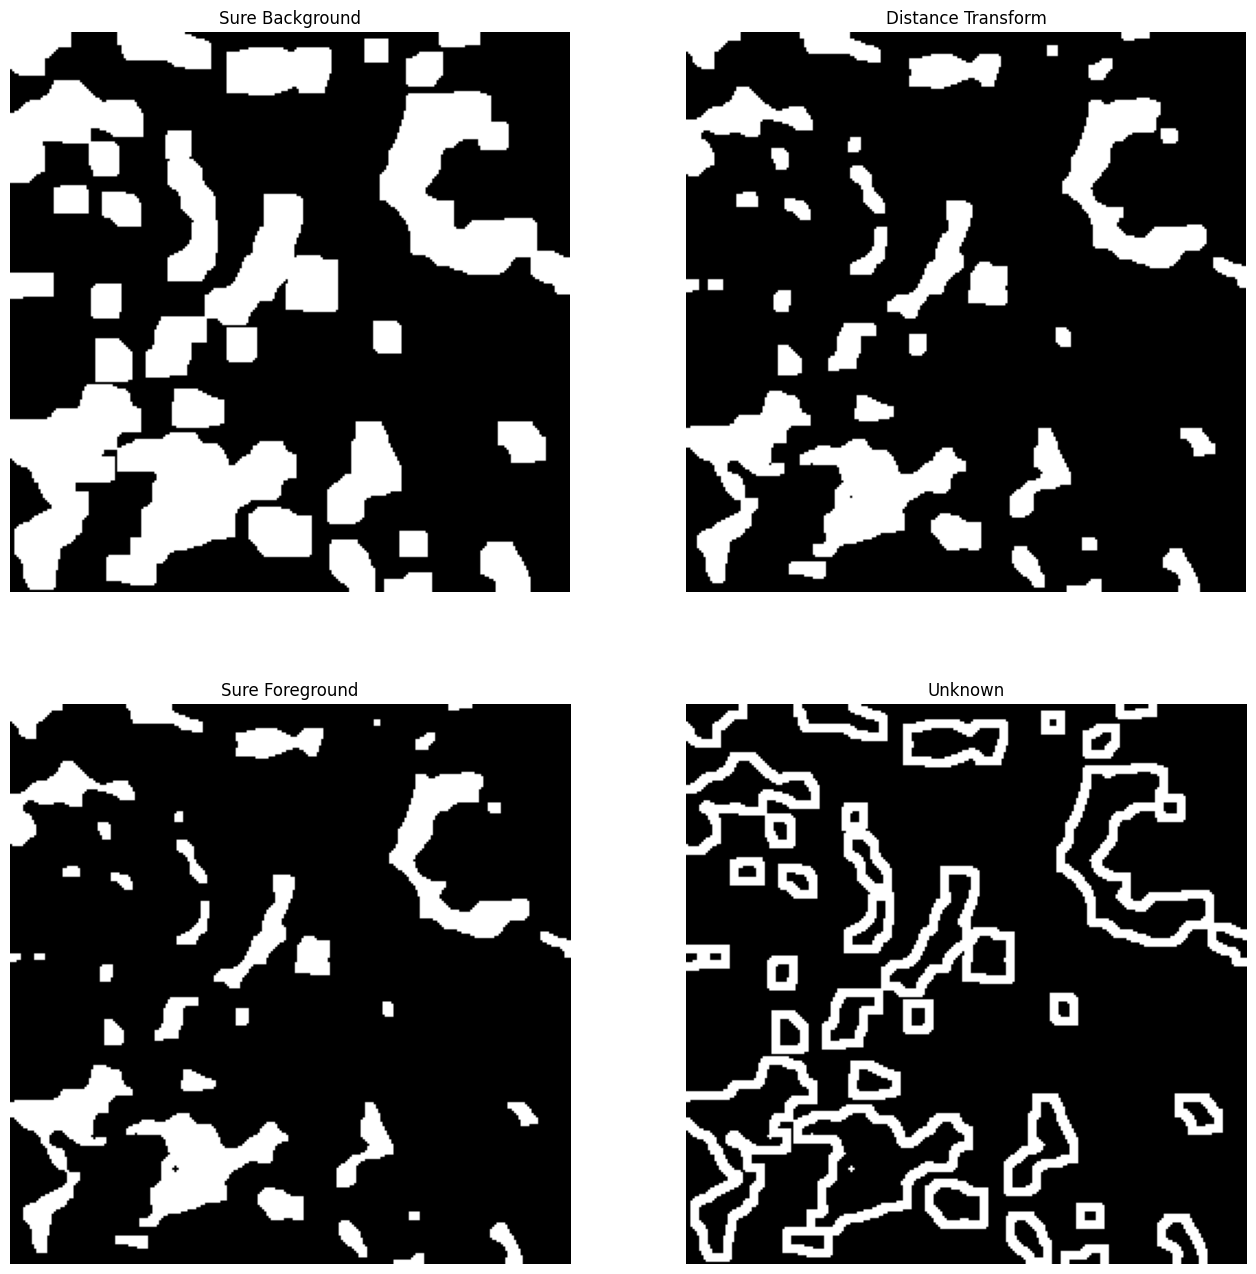

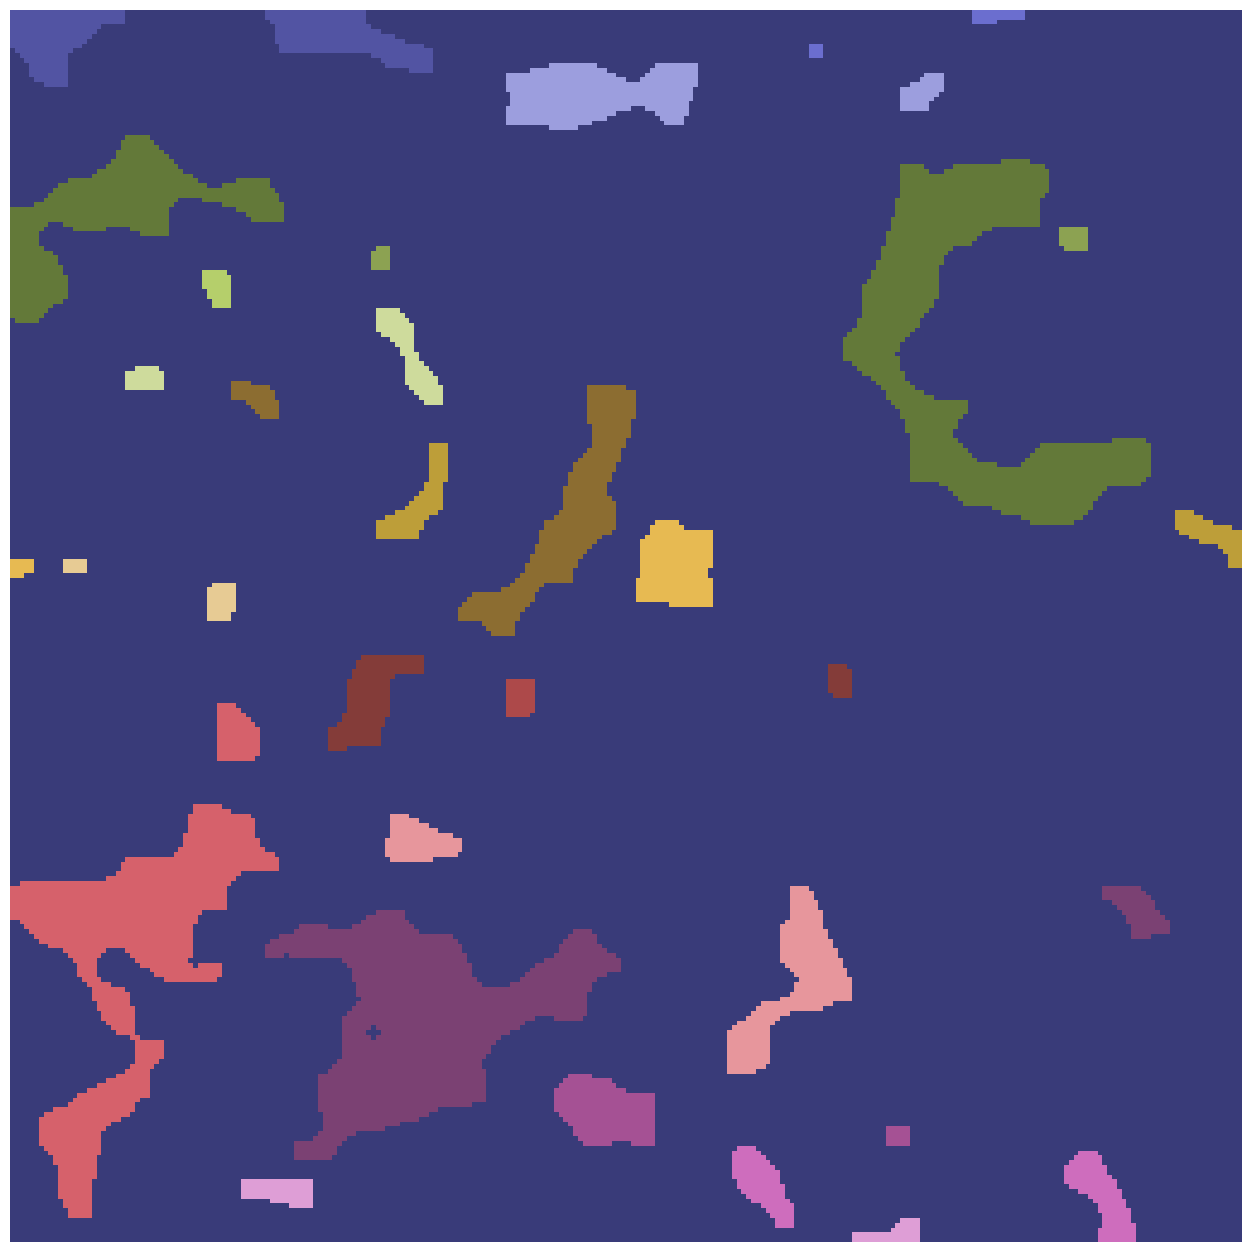

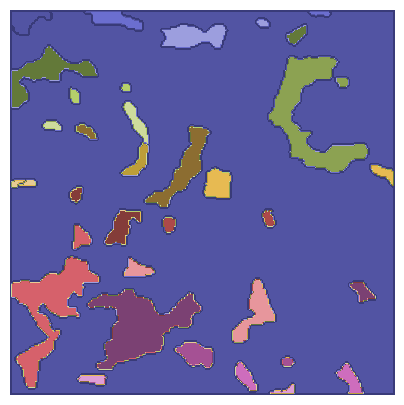

porosity 0.14403533935546875


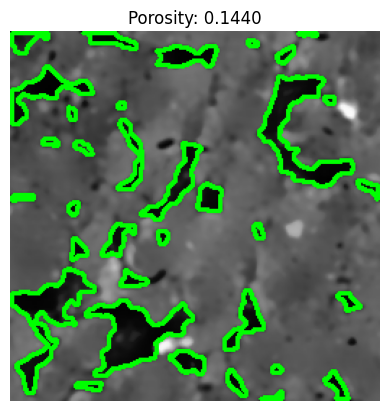

Porosity: 0.1440


In [13]:
import cv2
from IPython.display import Image, display
def imshow(img, ax=None):
    if ax is None:
        ret, encoded = cv2.imencode(".png", img)
        display(Image(encoded))
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

img = cv2.imread('D:\\OU\\MINES\\CroppedImages\\crop_0001.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)
ret, bin_img = cv2.threshold(gray,
                             0, 255, 
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imshow(bin_img)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, 
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)
imshow(bin_img)
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
# sure background area
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')
 
# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')
 
#foreground area
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)  
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')
 
# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')
 
plt.show()
# Marker labelling
# sure foreground 
ret, markers = cv2.connectedComponents(sure_fg)
 
# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

 
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Apply the watershed algorithm
markers = cv2.watershed(img, markers)

# Visualization of the result
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

# Process the labels to identify and calculate areas
labels = np.unique(markers)
coins = []

for label in labels[2:]:  # Exclude background and border labels
    target = np.where(markers == label, 255, 0).astype(np.uint8)
    contours, hierarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coins.append(contours[0])

# Draw the outlines for visualization
img_with_contours = cv2.drawContours(img.copy(), coins, -1, color=(0, 255, 0), thickness=2)

# Calculate porosity
total_pore_area = sum([cv2.contourArea(coin) for coin in coins])
total_image_area = img.shape[0] * img.shape[1]
porosity = total_pore_area / total_image_area
print("porosity",porosity)
# Show the final image with pore outlines
plt.imshow(img_with_contours, cmap='gray')
plt.title(f"Porosity: {porosity:.4f}")
plt.axis('off')
plt.show()

print(f"Porosity: {porosity:.4f}")